In [83]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import functools

In [84]:
def load_image(image):
  max_dim = 512
  image = tf.io.read_file(image)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim/long_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  return image

In [85]:
#download the images
content_path = "chicago.jpg"
style_path = "filter.jpg"

In [86]:
def imshow(image,title = None):
  if len(image.shape) > 3:
    image = tf.squeeze(image , axis=0)
    plt.imshow(image)
    if title:
      plt.title(title)

In [87]:
content_image = load_image(content_path)
style_image = load_image(style_path)
print(content_image.shape, style_image.shape)

(1, 340, 512, 3) (1, 512, 512, 3)


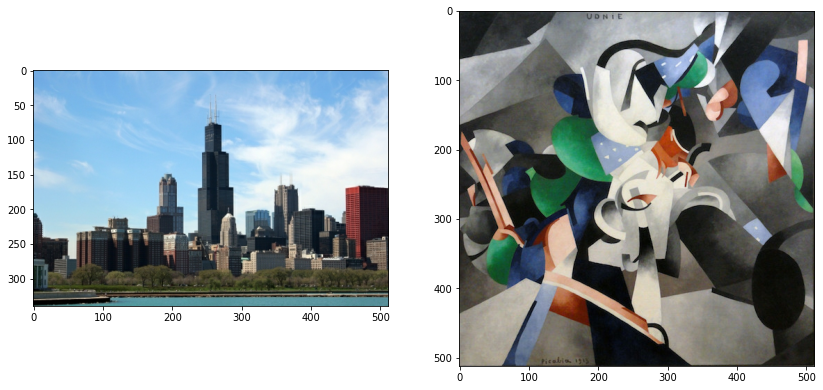

In [88]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
imshow(content_image)
plt.subplot(1,2,2)
imshow(style_image)

In [89]:
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
x = tf.image.resize(x, (224,224))
x.shape

TensorShape([1, 224, 224, 3])

In [90]:
vgg = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [91]:
for layer in vgg.layers:
  print(layer.name)

input_10
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [92]:
content_layer = ["block5_conv2"]

style_layers = ["block1_conv1",
              "block2_conv1",
              "block3_conv1",
              "block4_conv1",
              "block5_conv1"]
num_content_layers = len(content_layer)
num_style_layers = len(style_layers)

In [93]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [94]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

In [95]:
for output in style_outputs:
  print(output.shape)

(1, 512, 512, 64)
(1, 256, 256, 128)
(1, 128, 128, 256)
(1, 64, 64, 512)
(1, 32, 32, 512)


In [96]:
for name,output in zip(style_layers, style_outputs):
  print(name)
  print("shape", output.numpy().shape)
  print("min", output.numpy().min())
  print("max", output.numpy().max())
  print("mean", output.numpy().mean())
  print()

block1_conv1
shape (1, 512, 512, 64)
min 0.0
max 839.30615
mean 20.07325

block2_conv1
shape (1, 256, 256, 128)
min 0.0
max 4078.1772
mean 122.11407

block3_conv1
shape (1, 128, 128, 256)
min 0.0
max 7027.3516
mean 127.51552

block4_conv1
shape (1, 64, 64, 512)
min 0.0
max 14745.873
mean 519.1812

block5_conv1
shape (1, 32, 32, 512)
min 0.0
max 2873.4424
mean 49.52341



In [97]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum("fijc,fijd->fcd",input_tensor,input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
  return result/num_locations

In [98]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layer):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layer)
    self.style_layers = style_layers
    self.content_layer = content_layer
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
  def call(self, inputs):
    inputs = inputs * 255.0
    preprocess_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocess_input)
    style_outputs , content_outputs = (outputs[:self.num_style_layers],outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
    content_dict = {content_name:value for content_name,value in zip(self.style_layers, content_outputs)}
    style_dict = {style_name:value for style_name,value in zip(self.style_layers, style_outputs)}
    return {"content":content_dict, "style":style_dict}

In [99]:
extractor = StyleContentModel(style_layers, content_layer)
result = extractor(tf.constant(content_image))

print("Styles :")
for name,output in sorted(result["style"].items()):
  print(" ",name)
  print("shape", output.numpy().shape)
  print("min", output.numpy().min())
  print("max", output.numpy().max())
  print("mean", output.numpy().mean())
  print()

Styles :
  block1_conv1
shape (1, 64, 64)
min 0.027420871
max 55979.035
mean 699.47766

  block2_conv1
shape (1, 128, 128)
min 0.0
max 91163.484
mean 16390.59

  block3_conv1
shape (1, 256, 256)
min 0.0
max 354304.6
mean 15713.154

  block4_conv1
shape (1, 512, 512)
min 0.0
max 4512013.5
mean 232466.42

  block5_conv1
shape (1, 512, 512)
min 0.0
max 159752.55
mean 2205.247



In [100]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

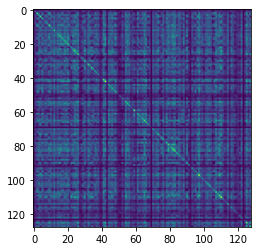

In [101]:
plt.imshow(style_targets["block2_conv1"].numpy()[0])

In [102]:
image = tf.Variable(content_image)

In [103]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [104]:
optim = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

In [105]:
style_weight = 1e-2
content_weight = 1e4

In [106]:
def style_content_loss(outputs):
  style_outputs = outputs["style"]
  content_outputs = outputs["content"]
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                          for name in style_outputs.keys()])
  style_loss *= style_weight/ num_style_layers
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                          for name in content_outputs.keys()])
  content_loss *= content_weight/ num_content_layers
  loss = content_loss + style_loss
  return loss

In [107]:
@tf.function
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
  grad = tape.gradient(loss,image)
  optim.apply_gradients([(grad,image)])
  image.assign(clip_0_1(image))

In [108]:
for i in range(4):
  train_step(image)

In [109]:
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

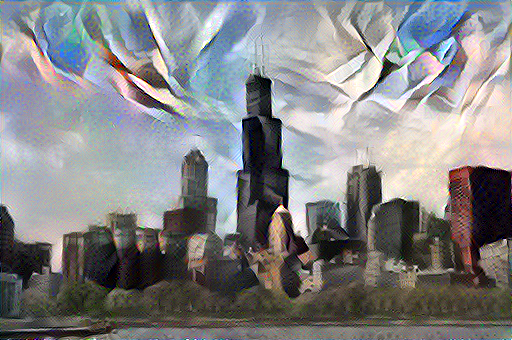

9


In [110]:
import IPython.display as display
from PIL import Image
epochs = 10
steps_per_epoch = 100
step = 0
for epoch in range(epochs):
  for steps in range(steps_per_epoch):
    step += 1
    train_step(image)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
  print(epoch)